In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

In [66]:
# 데이터 전처리
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Resize((50, 50))
])

In [67]:
# 데이터셋 로드
img_root = 'data'
dataset = ImageFolder(root=img_root, transform=transform)
for i in dataset.classes:
    print(f'"{i}', end='\",')

"ev6","ev9","qm3","qm6","sm3","sm6","xm3","그랜저","넥쏘","더 뉴 아반떼","렉스턴","스타리아","싼타페","쏘나타","아우디 a4","아우디 a5","아우디 a6","아우디 a7","아우디 e-tron","아우디 q3","아우디 q7","아우디 q8","아이오닉5","아이오닉6","제네시스 g70","제네시스 g90","제네시스 gv70","코나","코란도","토레스","투싼",

In [68]:
# 데이터셋 분할 (학습/검증/테스트)
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


# 하이퍼파라미터 설정
batch_size = 32
num_epochs = 30
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [69]:
import torch.nn.functional as F


# CNN 모델 정의
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 12 * 12, 64)
        self.fc2 = nn.Linear(64, 31)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 12 * 12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [70]:
# 모델 인스턴스 생성
model = CNNModel().to(device)

# 손실 함수 정의
criterion = nn.CrossEntropyLoss().to(device)

# 옵티마이저 정의
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 리스트 정의
trainList = []
valList = []
testList = []



In [71]:
torch.cuda.is_available()

True

In [72]:
# 학습 함수
def train(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        trainList.append(loss)
    return running_loss / len(loader)

In [73]:
# 검증 함수
def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            valList.append(loss)
    return running_loss / len(loader)

In [74]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
SCHEDULERS = ReduceLROnPlateau(optimizer, mode = 'min', patience = 3, verbose = True)
cnt = 0

# 학습 루프
best_val_loss = 10000
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion)
    val_loss = validate(model, val_loader, criterion)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
    if SCHEDULERS.num_bad_epochs >= SCHEDULERS.patience:
        print(f"Early stopping at epoch {epoch}")
        break
    # print(epoch)

Epoch 1/30, Train Loss: 3.4322, Val Loss: 3.3998
Epoch 2/30, Train Loss: 3.2279, Val Loss: 2.9603
Epoch 3/30, Train Loss: 2.5843, Val Loss: 2.1292
Epoch 4/30, Train Loss: 1.8727, Val Loss: 1.4893
Epoch 5/30, Train Loss: 1.2817, Val Loss: 1.1130
Epoch 6/30, Train Loss: 0.9261, Val Loss: 0.8368
Epoch 7/30, Train Loss: 0.7751, Val Loss: 0.8213
Epoch 8/30, Train Loss: 0.5440, Val Loss: 0.5126
Epoch 9/30, Train Loss: 0.4063, Val Loss: 0.4754
Epoch 10/30, Train Loss: 0.3843, Val Loss: 0.4206
Epoch 11/30, Train Loss: 0.3347, Val Loss: 0.3315
Epoch 12/30, Train Loss: 0.4085, Val Loss: 0.3990
Epoch 13/30, Train Loss: 0.2371, Val Loss: 0.2678
Epoch 14/30, Train Loss: 0.2974, Val Loss: 0.3338
Epoch 15/30, Train Loss: 0.2067, Val Loss: 0.2012
Epoch 16/30, Train Loss: 0.1571, Val Loss: 0.1953
Epoch 17/30, Train Loss: 0.1249, Val Loss: 0.1972
Epoch 18/30, Train Loss: 0.0912, Val Loss: 0.1642
Epoch 19/30, Train Loss: 0.0851, Val Loss: 0.1870
Epoch 20/30, Train Loss: 0.0731, Val Loss: 0.1464
Epoch 21/

In [75]:
device

device(type='cuda')

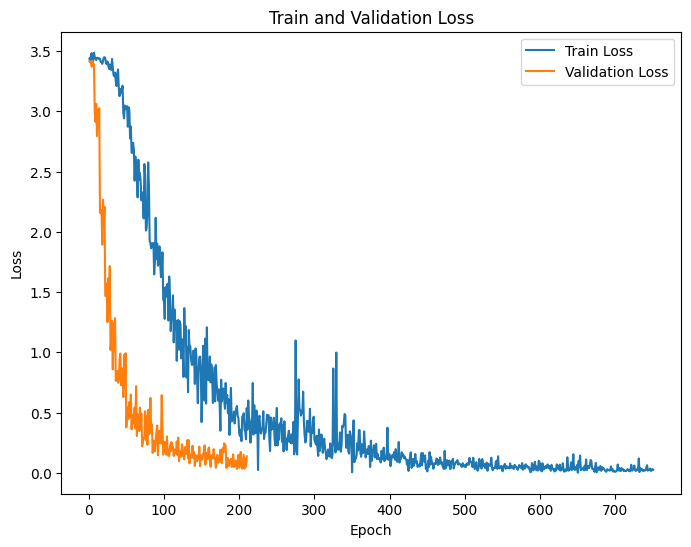

Test Accuracy: 96.40%


In [76]:
import matplotlib.pyplot as plt

# 에포크 loss 시각화
plt.figure(figsize=(8, 6))
x = range(1,len(trainList)+1)
plt.plot(x, torch.tensor(trainList).detach().numpy(), label='Train Loss')
x = range(1,len(valList)+1)
plt.plot(x, torch.tensor(valList).detach().numpy(), label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# 테스트 함수
def test(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    testList.append(accuracy)
    return accuracy

# 모델 로드 및 테스트
model.load_state_dict(torch.load('best_model.pth'))
test_accuracy = test(model, test_loader)
print(f'Test Accuracy: {test_accuracy:.2f}%')


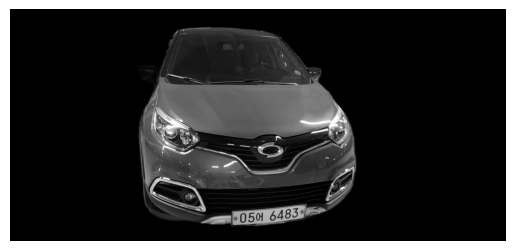

예측 클래스: ev9
예측 확률: 100.00%


In [79]:
from PIL import Image
# 테스트 결과 출력

img_path = 'test/image2.png'  # 테스트 이미지 경로

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # 그레이스케일 변환
    transforms.ToTensor(),
    transforms.Resize((50, 50))
])

img = Image.open(img_path).convert('L')
img_tensor = transform(img).unsqueeze(0).to(device)

model.eval()

with torch.no_grad():
    output = model(img_tensor)
    _, predicted = torch.max(output.data, 1)

plt.imshow(img, cmap='gray')  # 그레이스케일 이미지로 표시
plt.axis('off')
plt.show()

# 결과 출력
prob = torch.softmax(output, dim=1).detach().cpu().squeeze().numpy()
max_prob = max(prob)
rounded_prob = round(max_prob, 2)

class_names = ["ev6","ev9","qm3","qm6","sm3","sm6","test","xm3","그랜저","넥쏘","더 뉴 아반떼","렉스턴","스타리아","싼타페","쏘나타","아우디 a4","아우디 a5","아우디 a6","아우디 a7","아우디 e-tron","아우디 q3","아우디 q7","아우디 q8","아이오닉5","아이오닉6","제네시스 g70","제네시스 g90","제네시스 gv70","코나","코란도","토레스","투싼"]  # 클래스 이름 리스트 (실제 클래스 이름으로 변경해야 함)
predicted_class = class_names[predicted.item()]

print(f"예측 클래스: {predicted_class}")
print(f"예측 확률: {rounded_prob*100:.2f}%")